In [1]:
import tensorflow as tf
import random
import numpy as np
import pandas as pd
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint 
from sklearn import metrics  
import time

import keras

import matplotlib.pyplot as plt

import itertools
import helper

from keras.models import Model,Sequential
from keras.layers import Input
from keras.layers.core import Dropout,Flatten,Dense
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.metrics import confusion_matrix,classification_report
from keras.applications.densenet import DenseNet201
from keras.applications.resnet import ResNet152

from keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir="/content/drive/MyDrive/dataset 2/train2"

In [ ]:
train_datagen_aug = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range = 20,
                                   horizontal_flip = True)

In [ ]:
training_set_aug = train_datagen_aug.flow_from_directory(directory= train_dir,
                                               target_size=(224, 224), # As we choose 64*64 for our convolution model
                                               batch_size=50,
                                               class_mode='categorical') # for 2 class binary 
label_map = (training_set_aug.class_indices)
print("Target Classes Mapping Dict:\n")
print(label_map)



Found 17500 images belonging to 35 classes.
Target Classes Mapping Dict:

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Cherry_(including_sour)___Healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 6, 'Corn_(maize)___Common_rust_': 7, 'Corn_(maize)___Healthy': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Grape___Black_rot': 10, 'Grape___Esca_(Black_Measles)': 11, 'Grape___Healthy': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Orange___Haunglongbing_(Citrus_greening)': 14, 'Peach___Bacterial_spot': 15, 'Peach___healthy': 16, 'Pepper,_bell___Bacterial_spot': 17, 'Pepper,_bell___healthy': 18, 'Potato___Early_blight': 19, 'Potato___Healthy': 20, 'Potato___Late_blight': 21, 'Squash___Powdery_mildew': 22, 'Strawberry___Healthy': 23, 'Strawberry___Leaf_scorch': 24, 'Tomato___Bacterial_spot': 25, 'Tomato___Early_blight': 26, 'Tomato___Healthy': 27, 'Tomato___Late_b

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0025, patience=2, verbose=1)

In [ ]:
base_model = DenseNet201(include_top=False,
                         input_shape=(224,224,3),
                         weights='imagenet',
                         pooling="avg"
                     )

base_model.trainable = False
image_input = Input(shape=(224, 224, 3))

x = base_model(image_input,training = False)

x = Dense(256,activation = "relu")(x)
x = Dropout(0.2)(x)

x = Dense(128,activation = "relu")(x)
x = Dropout(0.2)(x)

image_output = Dense(35,activation="softmax")(x)

model = Model(image_input,image_output)

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"]) 
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 dense_3 (Dense)             (None, 256)               491776    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 35)                4515

In [ ]:
hist = model.fit(training_set_aug, epochs=30, callbacks=[callback])

Epoch 1/30
350/350 [==============================] - 5060s 14s/step - loss: 1.1081 - accuracy: 0.6762
Epoch 2/30
350/350 [==============================] - 244s 698ms/step - loss: 0.4009 - accuracy: 0.8719
Epoch 3/30
350/350 [==============================] - 245s 699ms/step - loss: 0.2867 - accuracy: 0.9052
Epoch 4/30
350/350 [==============================] - 242s 691ms/step - loss: 0.2472 - accuracy: 0.9155
Epoch 5/30
350/350 [==============================] - 242s 692ms/step - loss: 0.2159 - accuracy: 0.9278
Epoch 6/30
350/350 [==============================] - 243s 694ms/step - loss: 0.1927 - accuracy: 0.9361
Epoch 7/30
350/350 [==============================] - 243s 694ms/step - loss: 0.1780 - accuracy: 0.9405
Epoch 8/30
350/350 [==============================] - 243s 693ms/step - loss: 0.1609 - accuracy: 0.9453
Epoch 9/30
350/350 [==============================] - 242s 691ms/step - loss: 0.1546 - accuracy: 0.9461
Epoch 10/30
350/350 [==============================] - 242s 690ms

In [ ]:
model.save('/content/drive/MyDrive/cnnmodel.model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/cnnmodel.model/assets


In [3]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/cnnmodel.model') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.h5', 'wb') as f:
  f.write(tflite_model)

In [4]:
image_path = '/content/drive/MyDrive/project/test/AppleCedarRust1.JPG'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
input_arr = input_arr.astype('float32')/255

In [ ]:
predictions = model.predict(input_arr)
predicted_class = np.argmax(predictions, axis=-1)
print(predicted_class)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
history_dict = hist.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy'])


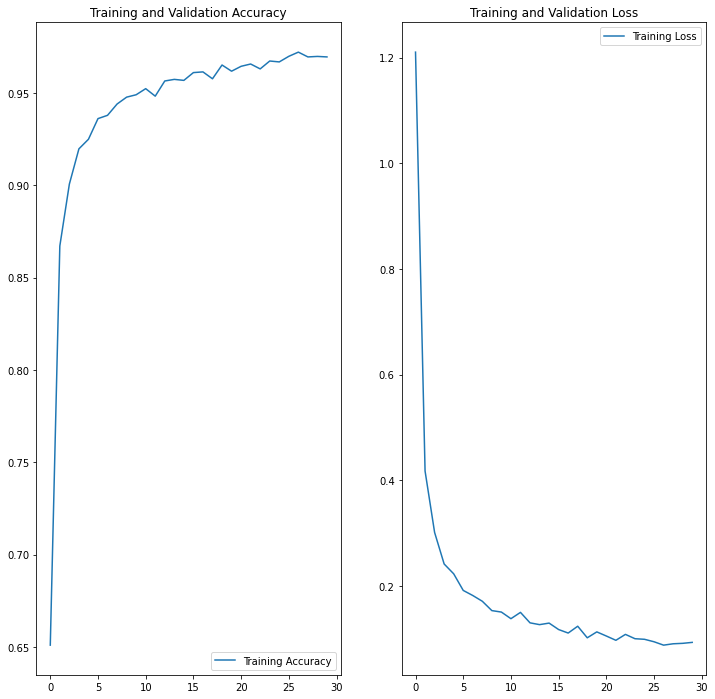

In [ ]:
acc = hist.history['accuracy']


loss = hist.history['loss']


epochs_range = range(30)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training Loss')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()